The [lvlspy API](https://pypi.org/project/lvlspy/) was developed to create an easy-to-use tool set that can handle nuclear level data and facilitate calculations. Tutorials on how to fully utilize the API can be found [here](https://github.com/jaadt7/lvlspy_tutorial). This notebook will utilize the API to calculate the effective transition rate between the isomeric and ground state of $^{26}\mathrm{Al}$. The calculation itself is detailed in the paper by [Gupta and Meyer](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.64.025805).

To start things off, we check and (quietly) install any missing required python packages and import them.

In [2]:
import sys, subprocess,pkg_resources
required = {'numpy','matplotlib','lvlspy','ipython'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    subprocess.check_call([sys.executable,'-m','pip','install','--quiet',*missing])

import numpy as np
import lvlspy.spcoll as lc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply

We define the generalized functions according to the methods defined in the aforementioned paper. The transfer properties function takes the rate matrix as input and extracts the Destruction Matrix diagonal, and sets up the Transfer matrix and the Production vectors. In the paper, the 'ij' subscripts refer to transitions from level 'i' into level 'j'. This however does not correspond to the 'ith' row and 'jth' column of the matrix. The index swap in the function takes care of this change.

In the lambda_effective function, the effective decay rate and the excitation rate are calculated between the ground and isomeric state. However, this notebook deviates from the method described in the paper by ignoring the approximation surrounding $(I - F^{T})^{-1}$ and calculates it directly. This leads to a change of form for $\lambda_{12}^{eff}$ and $\lambda_{21}^{eff}$ to $\Lambda_{1}(1 - (f_{1}^{in})^{T}(I - F^{T})^{-1})f_{1}^{out}$ and $\Lambda_{2}(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ respectively.

The gamma_calculator function calculates $\Gamma_{q}^{in}$ and $\Gamma_{q}^{out}$ using the transfer properties.

The f's and Newton-Raphson functions are related to another and are used to solve coupled systems.

In [3]:
def transfer_properties(rate_matrix):
    
    n = len(rate_matrix)
    
    lambda_1_in = rate_matrix[0,2:n]
    lambda_2_in = rate_matrix[1,2:n]

    lambda_1_out = rate_matrix[2:n,0]
    lambda_2_out = rate_matrix[2:n,1]

    LAMBDA = np.diag(rate_matrix)
    
    f1_out = lambda_1_out/LAMBDA[0]
    f2_out = lambda_2_out/LAMBDA[1]

    f1_in = lambda_1_in/LAMBDA[2:n]
    f2_in = lambda_2_in/LAMBDA[2:n]

    F = rate_matrix.T
    
    F = F[2:n,2:n]
    F = F/LAMBDA[2:n,None] #This only works if the arrays are numpy arrays
    
    np.fill_diagonal(F,0.0)
  
    return F,f1_in,f1_out,f2_in,f2_out,LAMBDA


def lambda_effective(T,sp):

    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f1_in,f1_out,f2_in,f2_out,LAMBDA = transfer_properties(rate_matrix)
    n = len(F)
    #Lambda_21_eff
    l_21 = LAMBDA[1]*np.matmul(f1_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f2_out))
    #Lambda_12_eff
    l_12 = LAMBDA[0]*(1.0 - np.matmul(f1_in,np.matmul(np.linalg.inv(np.identity(n) - F.T),f1_out)))
            
    return l_12,l_21

def gamma_calculator(T,sp):
    rate_matrix = np.abs(sp.compute_rate_matrix(T))
    F,f1_in,f1_out,f2_in,f2_out,LAMBDA = transfer_properties(rate_matrix)

    n = len(F)

    #gamma in
    g1_in = np.matmul(np.linalg.inv(np.identity(n) - F),f1_in)
    g2_in = np.matmul(np.linalg.inv(np.identity(n) - F),f2_in)

    #gamma out
    g1_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f1_out)
    g2_out = np.matmul(np.linalg.inv(np.identity(n) - F.T),f2_out)

    return g1_out,g1_in,g2_out,g2_in

def f1(Y_guess,Y_old,dt,l,y):
    return Y_guess[0]*(dt*l + 1.0) - dt*l*y*Y_guess[1] - Y_old[0]

def f2(Y_guess,Y_old,dt,l,y):
    return Y_guess[1]*(1.0 + dt*l) - dt*l*Y_guess[0]/y - Y_old[1]

def newton_raphson(t,tol,Y,y1_eq,y2_eq,l12,l21):
    Y_guess = Y_old   = Y
    
    n = len(t)
    cut_off = n

    y_eq = y1_eq/y2_eq

    delta = np.ones(2,dtype = 'float64')

    for i in range(1,n):
        dt = t[i] - t[i-1]
        #matrix A changes with each dt
        A = np.array([[1.0 + dt*l12,-dt*l12*y_eq],[-dt*l21/y_eq,1.0 + dt*l21]])
        while (max(abs(delta)) >= tol):
            b = np.array([-f1(Y_guess,Y_old,dt,l12,y_eq),-f2(Y_guess,Y_old,dt,l21,y_eq)])
            delta = np.linalg.solve(A,b)
            Y_guess += delta            
        
        delta = np.ones(2) #reset the delta's to make sure the while loop runs a calculation
        Y_old = Y_guess
        Y = np.vstack((Y,Y_old))
        phi1 = Y[len(Y)-1,0]/y1_eq
        phi2 = Y[len(Y)-1,1]/y2_eq
        if((1.0 - phi2/phi1) <= 1e-6):
            cut_off = i
            break

    return Y,cut_off

Here we import our XML containing the level data pertaining to $^{26}\mathrm{Al}$. A tutorial to create your own XML with a different species and levels can be found [here](https://github.com/jaadt7/lvlspy_tutorial). If you wish to use it with this notebook, simply place the file in the same directory as the notebook and replace the XML name and the species name you are studying.

In [4]:
#setup the collection array to read the xml and load the al26 data
new_coll = lc.SpColl()
new_coll.update_from_xml('al26_22_level.xml')#loading the XML

sp = new_coll.get()['al26'] #species name

#Temperature Range in K
T = np.logspace(8,10)

#initializing the rate arrays as a function of temperature
lambda_21_eff = np.empty(len(T))
lambda_12_eff = np.empty(len(T))

#Calculating the effective transition rates
for i,t in enumerate(T):
    lambda_12_eff[i],lambda_21_eff[i] = lambda_effective(T[i],sp)

Here we graph the results. We see that the graph follows the trend in Fig. 1 of the paper quiet well. The major difference here is for $T_{9} > 1.1$, the rate isn't as high. This is attributed to the fact that the XML being used has only 22 energy levels while the paper's calculation used 67. This matters since the effective rate is calculated via indirect transitions from upper lying states. The less higher-end states you have, the less contribution you will have at higher temperatures since they mainly populated under said condition.

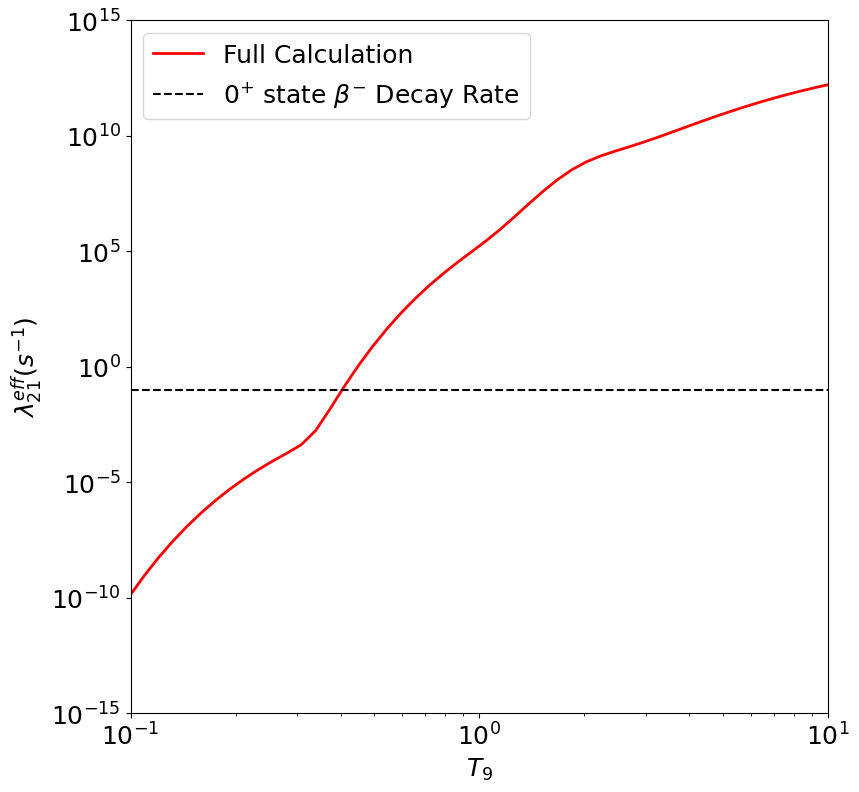

In [5]:
fontsize = 18

plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize
plt.xscale('log')
plt.yscale('log')

plt.ylim([1.e-15,1.e+15])
plt.xlim([np.min(T)/1e+9,np.max(T)/1e+9])

plt.plot(T/1e+9,lambda_21_eff,color = 'red',linewidth = 2,label = 'Full Calculation')

plt.ylabel(r'$\lambda_{21}^{eff} (s^{-1})$')
plt.xlabel(r'$T_{9}$')

plt.yticks([1e-15,1e-10,1e-5,1e0,1e+5,1e+10,1e+15])

plt.axhline(y = 1.e-1,ls = '--',color = 'black',label = r'$0^{+}$ state $\beta^{-}$ Decay Rate')

plt.legend()
plt.show()

The effective rate could be understood via a combinatorial interpretation. The expression $(f_{1}^{in})^{T}(I - F^{T})^{-1}f_{2}^{out}$ from $\lambda_{21}^{eff}$ is actually the effective branching ratio in terms of Graph Theory. The "cascade probability vectors" are defined as $\Gamma_{q}^{in} = (I - F)^{-1}f_{q}^{in}$. The term cascade refers to the de-excitation from higher states into state 'q'. The paper also defines the 'infinite'-arc generalization of $f_{q}^{out}$ with $\Gamma_{q}^{out} = (I - F^{T})^{-1}f_{q}^{out}$. They then go through the proof to rewrite $\lambda_{21}^{eff} = (\lambda_{2}^{out})^{T}\Gamma_{1}^{in}$.

Other than cleaning up the expression for the effective rates, the $\Gamma$'s play another role, that of calculating the fugacity of each state. Fugacity here deviates away from the pressure definition it uses in thermodynamics, but the term was appropriated due to its description of a state's abundance likeliness to jump to another state with less fugacity. If two states have the same fugacity, they will not exchange abundances. Equilibrium is established when all states have the same fugacity of one.

To illustrate this method, we solve the following 2-species system of equations:

$\begin{cases}
\frac{d Y_{1}}{dt} = -\lambda_{12}^{eff}(Y_{1} - Y_{2}\frac{Y_{1}^{eq}}{Y_{2}^{eq}})\\
\frac{d Y_{2}}{dt} = -\lambda_{21}^{eff}(Y_{2} - Y_{1}\frac{Y_{2}^{eq}}{Y_{1}^{eq}})
\end{cases}$


 via a Newton-Raphson solver, and use the $\Gamma$'s to update the fugacities of the higher states. This has a computational benefit over solving the evolution of the 22-level system directly, which will be illustrated as well. To those running the the notebook in Google Colab or Visual Studio code, there is runtime stamped at each cell to indicate how long it ran for.

In [6]:
#Temperature in Kelvin
T = 2e+9

#calculate gamma's

g1_out,g1_in,g2_out,g2_in = gamma_calculator(T,sp)

#time array
t = np.logspace(-15,0,300)

#equilibrium abundances. The API calculates them for the whole system. For this calculation
#we will use only that for the ground and isomeric state
eq_prob = sp.compute_equilibrium_probabilities(T)
y1_eq,y2_eq = eq_prob[0],eq_prob[1]

#initial abundances. System setup such that the system starts in the ground state.
Y = np.array([1.0,0.0])

#toleranace for Newton-Raphson convergence
tol = 1e-6

#calculating the effective transition rates
l12,l21 = lambda_effective(T,sp)

#evolving the system
Y,cut_off = newton_raphson(t,tol,Y,y1_eq,y2_eq,l12,l21)

#setting up fugacity matrix as function of time
n_rows, n_columns = len(sp.get_levels()),cut_off+1

PHI = np.empty([n_rows,n_columns])

PHI[0,:], PHI[1,:] = Y[:,0]/y1_eq, Y[:,1]/y2_eq

#calculating fugacities based on combination of phi1 and phi2 (eqn 5.8 in paper)
for i in range(n_columns):
    PHI[2:n_rows,i] = g1_in*PHI[0,i] + g2_in*PHI[1,i]

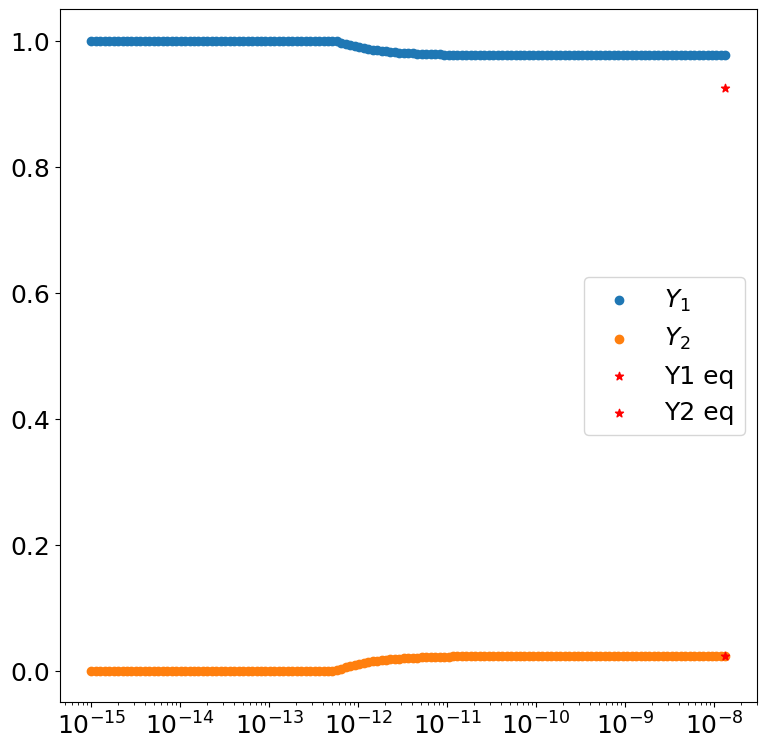

In [7]:
plt.figure(figsize = (9,9))
plt.rcParams['font.size'] = fontsize

plt.scatter(t[0:cut_off+1],Y[:,0],label = r'$Y_{1}$')
plt.scatter(t[0:cut_off+1],Y[:,1],label = r'$Y_{2}$')
plt.scatter(t[cut_off],y1_eq,marker ='*',color = 'red',label = 'Y1 eq')
plt.scatter(t[cut_off],y2_eq,marker ='*',color = 'red',label = 'Y2 eq')


plt.xscale('log')

plt.legend()
plt.show()

Here we will animate the evolution of the fugacities for the 22 levels in our xml

In [8]:
fig = plt.figure(figsize = (10,10))
plt.rcParams['font.size'] = fontsize
#extract energies from the levels in the xml
levs = sp.get_levels()
E = np.empty(n_rows)
for i in range(n_rows):
    E[i] = levs[i].get_energy()

def updatefig(i):
    fig.clear()
    fig.suptitle(r'time (s): %8.2e; $T_{9}$ = %4.2f' %(t[i],T/1e+9))
    plt.scatter(PHI[0,i],E[0],color = 'green') #ground state
    plt.scatter(PHI[1,i],E[1],color = 'red') #isomer
    plt.scatter(PHI[2:n_rows-1,i],E[2:len(E)-1],color = 'black')
    plt.axvline(x = PHI[0,i],color = 'green')
    plt.axvline(x = PHI[1,i],color = 'red')
    plt.xlabel(r'$\phi$')
    plt.ylabel('E (keV)')
    plt.xscale('log')
    plt.xlim([1e-8,10])
    plt.draw()

anim = animation.FuncAnimation(fig,updatefig,cut_off)
display(HTML(anim.to_jshtml()))
plt.close() #closes the last frame

In [17]:
#sparse matrix test

T = 2e+9
A = sp.compute_rate_matrix(T)

print('got the rate matrix')
#sparse_rate = csc_matrix(A)
sparse_rate = csc_matrix(np.random.rand(22,22))
print('got the sparse matrix')
Y_0 = np.random.rand(n_rows)
#Y_0[0] = 1.0
print(Y_0)

Y_test = expm_multiply(sparse_rate,Y_0,start = 0, stop = 1,num = 50,endpoint = True)
print(Y_test)

got the rate matrix
got the sparse matrix
[0.61414211 0.17821089 0.44984092 0.48689194 0.73119713 0.66208851
 0.98919091 0.28458388 0.07110894 0.90013007 0.78962698 0.80826332
 0.37603419 0.59423968 0.49461954 0.47753505 0.35843634 0.05753869
 0.47460641 0.19301311 0.47604606 0.28828316]
[[6.14142108e-01 1.78210893e-01 4.49840915e-01 ... 1.93013115e-01
  4.76046061e-01 2.88283157e-01]
 [7.07144760e-01 3.05919233e-01 5.85164398e-01 ... 3.08056295e-01
  6.17731696e-01 4.20836611e-01]
 [8.20289412e-01 4.64750682e-01 7.53146966e-01 ... 4.50415079e-01
  7.95953642e-01 5.86247281e-01]
 ...
 [1.04059056e+04 1.60496201e+04 1.67808211e+04 ... 1.40262312e+04
  1.87746081e+04 1.67496300e+04]
 [1.29674153e+04 2.00007088e+04 2.09118350e+04 ... 1.74791325e+04
  2.33965356e+04 2.08729654e+04]
 [1.61594981e+04 2.49244486e+04 2.60597934e+04 ... 2.17820431e+04
  2.91562587e+04 2.60113522e+04]]
